In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib

import semisupervised_vae_lib as ss_vae_lib

# Load data

In [2]:
seed = 901

In [3]:
batch_size = 50

In [4]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(propn_sample = 1.0, propn_labeled = 1.0)
    
train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batch_size,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified


In [5]:
seed = 4353

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

# for batch_idx, d in enumerate(train_loader_unlabeled):
#     data_unlabeled = d
#     break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

In [6]:
def plot_cifar_image(image, fig, label = None):
    image_unscaled = image * cifar_data_utils.CIFAR_STD_TENSOR + cifar_data_utils.CIFAR_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    fig.imshow(img)
    
    if label is not None: 
        fig.set_title(cifar_data_utils.fine_labels_legend[label])
        

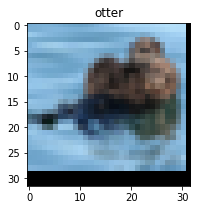

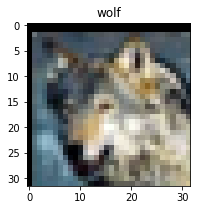

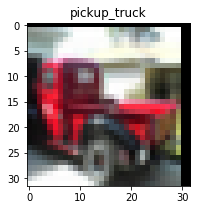

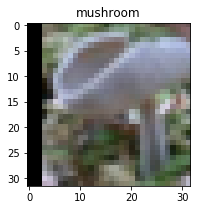

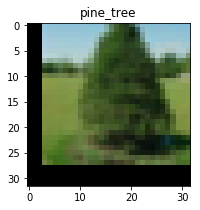

In [7]:
for n in range(5): 
    _, axarr = plt.subplots(1, 1, figsize=(3, 3))

    plot_cifar_image(data_labeled['image'][n, :, :], axarr, data_labeled['label'][n])

In [8]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [16]:
image_config = {'slen': 32,
                 'channel_num': 3,
                 'n_classes': 100}

cond_vae_config = {'kernel_num': 128,
                   'z_size': 128}

classifier_config = {'depth': 100,
                     'k': 12}

In [17]:
vae = cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config,
                                                            cond_vae_config,
                                                            classifier_config)


In [18]:
# Load results

file_base = '../cifar_vae_results/cifar_vae_densenet_true_labels_alllabeled'

which_epoch = 'epoch40'

enc_file = file_base + '_enc_' + which_epoch
dec_file = file_base + '_dec_' + which_epoch
classifier_file = file_base + '_classifier_' + which_epoch

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_classifier_final'


vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

SemiSupervisedVAE(
  (conditional_vae): CIFARConditionalVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (cond_encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2148, out_features=128, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=Tru

# Check losses

In [14]:
loss_array = np.loadtxt(file_base + '_loss_array.txt')

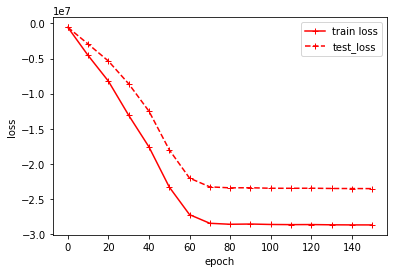

In [15]:
# plot losses
start_indx = 0

plt.plot(loss_array[0, start_indx:], loss_array[1, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[2, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

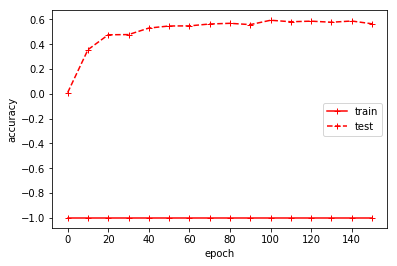

In [16]:
# plot trianing accuracy
plt.plot(loss_array[0, start_indx:], loss_array[3, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train', 'test'))

In [17]:
_, loss = vae.get_semisupervised_loss(data_unlabeled['image'], data_labeled['image'], 
                                      data_labeled['label'], 0, 0)
print(loss / data_unlabeled['image'].shape[0])

NameError: name 'data_unlabeled' is not defined

In [18]:
_, loss = vae.get_semisupervised_loss(test_data['image'], data_labeled['image'], data_labeled['label'], 0, 0)
print(loss / test_data['image'].shape[0])

tensor(-3.7271e+06)


# Look at classification accuracies 

In [19]:
labeled_accuracy, labeled_wrong_images, labeled_wrong_labels = \
    ss_vae_lib.get_classification_accuracy(vae.classifier, train_loader_labeled,
                                            return_wrong_images = True, max_images = 100)
    
print(labeled_accuracy)

tensor(0.7200)


In [20]:
unlabeled_accuracy, unlabeled_wrong_images, unlabeled_wrong_labels= \
    ss_vae_lib.get_classification_accuracy(vae.classifier, train_loader_unlabeled,
                                                return_wrong_images = True, 
                                                 max_images = np.Inf)
    
print(unlabeled_accuracy)

TypeError: object of type 'NoneType' has no len()

In [21]:
test_accuracy, test_wrong_images, test_wrong_labels = \
    ss_vae_lib.get_classification_accuracy(vae.classifier, test_loader,
                                                return_wrong_images = True, max_images = 100)

print(test_accuracy)

tensor(0.5867)


In [22]:
def get_topk_labels(class_weights, topk):
    assert len(class_weights.shape) == 1, 'this is implemented only for one observation at a time.'
    probs, indx = torch.topk(class_weights, k = topk)
    
    labels = []
    for i in range(topk): 
        labels.append(cifar_data_utils.fine_labels_legend[indx[i]])
        
    return probs, labels

In [23]:
log_q = vae.classifier(data_labeled['image'])
class_weights = torch.exp(log_q)

In [24]:
for n in range(10): 
    print(cifar_data_utils.fine_labels_legend[data_labeled['label'][n]])
    print(get_topk_labels(class_weights[n, :], topk = 3))

otter
(tensor([ 0.8384,  0.1284,  0.0331]), ['beaver', 'otter', 'seal'])
wolf
(tensor([ 0.9650,  0.0205,  0.0032]), ['wolf', 'fox', 'squirrel'])
pickup_truck
(tensor([ 0.7495,  0.2417,  0.0044]), ['pickup_truck', 'tractor', 'bus'])
mushroom
(tensor([ 0.8298,  0.1521,  0.0080]), ['kangaroo', 'dolphin', 'dinosaur'])
pine_tree
(tensor([ 0.9984,  0.0009,  0.0007]), ['pine_tree', 'maple_tree', 'oak_tree'])
skunk
(tensor([ 9.9998e-01,  1.6000e-05,  2.9907e-07]), ['skunk', 'raccoon', 'bear'])
pine_tree
(tensor([ 0.9919,  0.0048,  0.0031]), ['pine_tree', 'oak_tree', 'maple_tree'])
bus
(tensor([ 0.9933,  0.0065,  0.0001]), ['pickup_truck', 'bus', 'lawn_mower'])
poppy
(tensor([ 0.6494,  0.0996,  0.0546]), ['poppy', 'willow_tree', 'mushroom'])
mouse
(tensor([ 0.4782,  0.2421,  0.0366]), ['mouse', 'shrew', 'beaver'])


In [25]:
log_q = vae.classifier(test_data['image'])
class_weights = torch.exp(log_q)

for n in range(10): 
    print(cifar_data_utils.fine_labels_legend[test_data['label'][n]])
    print(get_topk_labels(class_weights[n, :], topk = 3))

sweet_pepper
(tensor([ 0.9636,  0.0331,  0.0030]), ['sweet_pepper', 'can', 'bottle'])
cattle
(tensor([ 0.4233,  0.2812,  0.2322]), ['flatfish', 'tank', 'cattle'])
possum
(tensor([ 0.9189,  0.0682,  0.0042]), ['porcupine', 'kangaroo', 'shrew'])
road
(tensor([ 0.9832,  0.0078,  0.0075]), ['road', 'sea', 'plain'])
bottle
(tensor([ 1.0000e+00,  5.9891e-08,  2.9809e-08]), ['bottle', 'can', 'rocket'])
crab
(tensor([ 0.5585,  0.3328,  0.0436]), ['bear', 'beaver', 'otter'])
castle
(tensor([ 0.9955,  0.0041,  0.0004]), ['castle', 'plain', 'mountain'])
porcupine
(tensor([ 0.9981,  0.0014,  0.0003]), ['porcupine', 'raccoon', 'beaver'])
kangaroo
(tensor([ 0.7335,  0.1123,  0.0473]), ['willow_tree', 'maple_tree', 'rabbit'])
shrew
(tensor([ 0.9854,  0.0054,  0.0038]), ['shrew', 'mouse', 'rabbit'])


# Check reconstructions

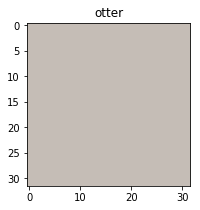

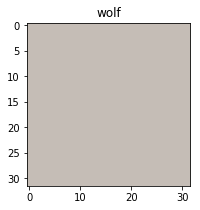

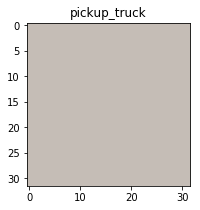

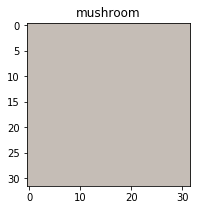

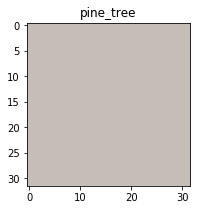

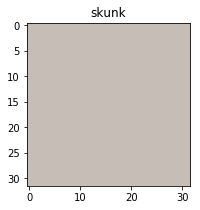

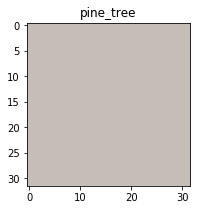

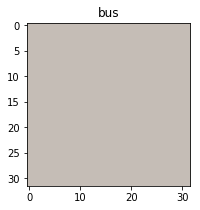

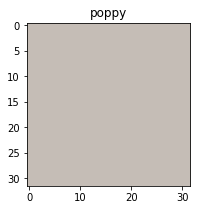

In [31]:
# Look at training images
use_true_labels = True
if use_true_labels: 
    labels=data_labeled['label']
else: 
    labels = None 

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_labeled['image'], labels = labels)

figsize = 8
for i in range(0, 9): 
    
    _, axarr = plt.subplots(1, 1, figsize=(3, 3))

    plot_cifar_image(image_mu.detach()[i, :, :, :], axarr, labels[i])

In [34]:
# Check the training images that were wrong

In [35]:
image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, unlabeled_wrong_images)
class_weights = torch.exp(torch.max(vae.classifier(unlabeled_wrong_images), dim = 1)[0])

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(unlabeled_wrong_images[i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(unlabeled_wrong_labels[i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}; prob {}\n'.format(\
                                                                z_ind[i], class_weights[i]))

NameError: name 'unlabeled_wrong_images' is not defined

In [31]:
# check a few test images 

In [32]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, test_data['image'], labels = None)


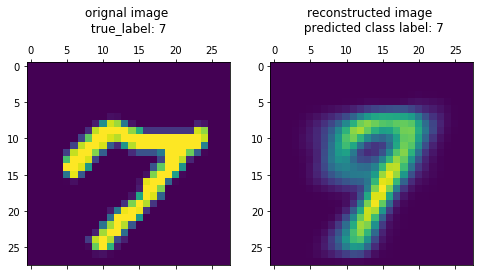

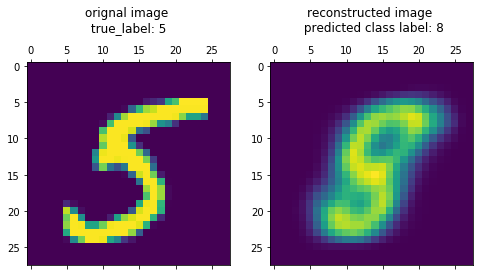

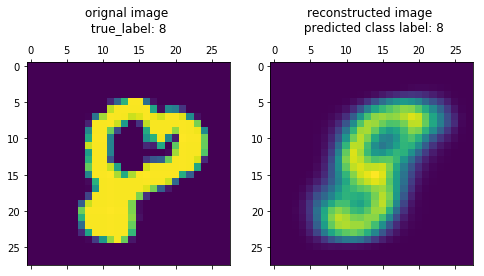

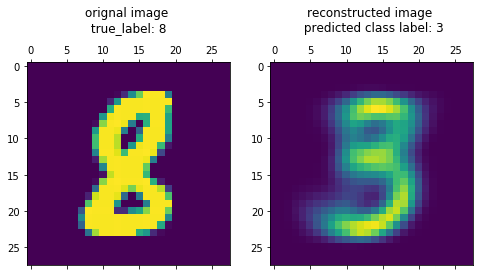

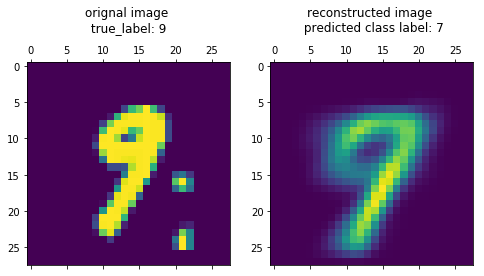

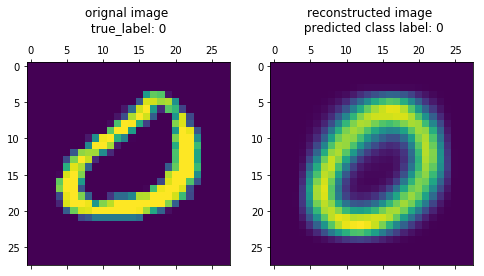

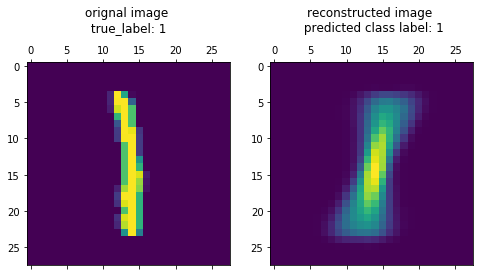

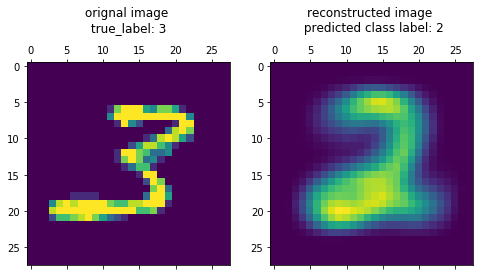

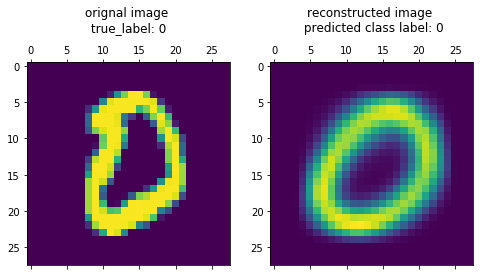

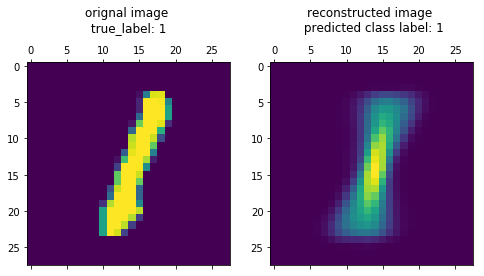

In [33]:
figsize = 8
for i in range(0, 10): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(test_data['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

# check conditional generation

In [44]:
num = 10
latent_params = torch.randn((10, latent_dim)) 

digit = 7
one_hot_z = mnist_utils.get_one_hot_encoding_from_int(torch.ones(num) * digit, n_classes)
recon_mean = vae.conditional_vae.decoder(latent_params, one_hot_z)

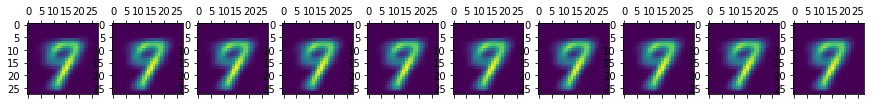

In [45]:
f, axarr = plt.subplots(1, num, figsize=(15, 15))

for i in range(0, num): 
    axarr[i].matshow(recon_mean[i, :, :].detach())


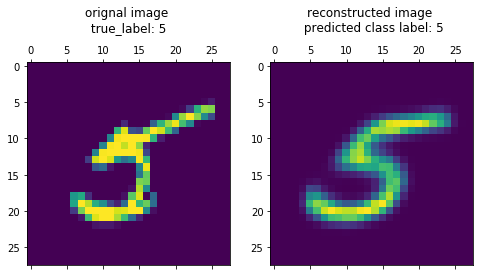

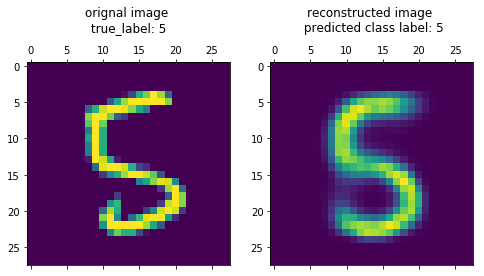

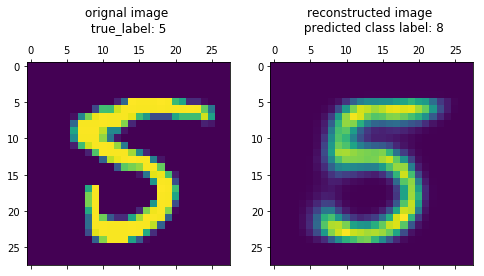

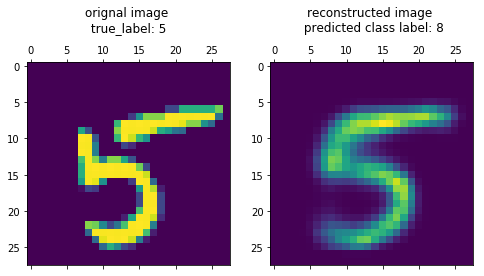

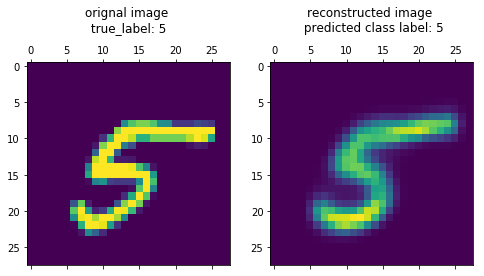

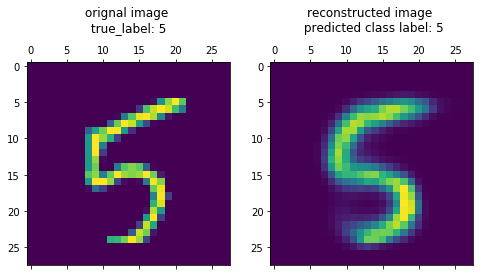

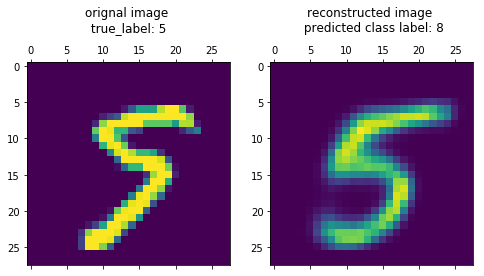

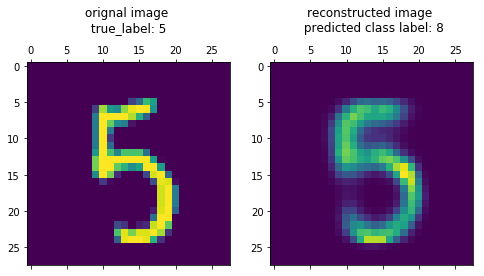

In [34]:
# labels = data_unlabeled['label']
labels = None 

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'], 
                                                    labels = labels)

figsize = 8
for i in range(0, 100): 
    if not (data_unlabeled['label'][i] == 5): 
        continue 
        
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(data_unlabeled['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))